This file combines the Beige Book chunk sentiment data and topic counts, preparing for tests with them both.

In [1]:
import pandas as pd

topic_data = pd.read_csv('aggregated_predictions_monthly.csv')

sentiment_data = pd.read_csv('sentiment_all_Beige_Book_chunks.csv')
# Drop duplicates from sentiment data
sentiment_data = sentiment_data.drop_duplicates()

topic_data['DATE'] = pd.to_datetime(topic_data['DATE'])
sentiment_data['DATE'] = pd.to_datetime(sentiment_data['DATE'])

# Merge on DATE
merged_data = pd.merge(topic_data, sentiment_data, on='DATE', how='outer')

# Save to csv
#merged_data.to_csv('full_Beige_Book_chunks_topics_sentmiment.csv', index=False)

# Regression models

Standardized sentiment (-1 to 1 scale) as DV

In [2]:
# This is the full list
# In the box below I remove lending and consumption because of multicollinearity

topic_columns = ["Employment", "Prices", "Consumption", "Manufacturing", "Construction",
                 "Lending", "Uncertainty", "Resources", "Transportation", "Outlook",
                "Labor", "Capital", "Trade"]

In [3]:
import statsmodels.api as sm

# Topic columns
topic_columns = ["Employment", "Prices", "Manufacturing", "Construction",
                 "Uncertainty", "Resources", "Transportation", "Outlook",
                "Labor", "Capital", "Trade"]

# Define X as including all the topic columns
X = merged_data[topic_columns]
X = sm.add_constant(X)
y = merged_data['normalized_sentiment']

# Fit a multiple linear regression model with robust standard errors
model = sm.OLS(y, X).fit(cov_type='HC3')

# Print the summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     normalized_sentiment   R-squared:                       0.712
Model:                              OLS   Adj. R-squared:                  0.705
Method:                   Least Squares   F-statistic:                     107.0
Date:                  Fri, 07 Feb 2025   Prob (F-statistic):          5.56e-119
Time:                          13:35:58   Log-Likelihood:                 88.935
No. Observations:                   470   AIC:                            -153.9
Df Residuals:                       458   BIC:                            -104.0
Df Model:                            11                                         
Covariance Type:                    HC3                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7178      0.046     15.609      0.000       0.628       0.808
Employment        -0.0136      0.004     -3.478      0.001      -0.021      -0.006
Prices            -0.0068      0.002     -2.756      0.006      -0.012      -0.002
Manufacturing     -0.0322      0.004     -9.068      0.000      -0.039      -0.025
Construction      -0.0069      0.002     -3.990      0.000      -0.010      -0.004
Uncertainty        0.0130      0.003      5.183      0.000       0.008       0.018
Resources         -0.0054      0.004     -1.386      0.166      -0.013       0.002
Transportation     0.0095      0.003      2.929      0.003       0.003       0.016
Outlook           -0.0599      0.006    -10.674      0.000      -0.071      -0.049
Labor             -0.0058      0.002     -2.556      0.011      -0.010      -0.001
Capital           -0.0345      0.005     -6.296      0.000      -0.045      -0.024
Trade              0.0037      0.002      1.806      0.071      -0.000       0.008
==============================================================================
Omnibus:                       17.998   Durbin-Watson:                   1.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.023
Skew:                          -0.483   Prob(JB):                     7.40e-05
Kurtosis:                       3.195   Cond. No.                         89.2
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [4]:
# Autocorrelation in the previous model, as indicated by Durbin-Watson statistic well below 2
# Fit a GLS model with first-order autocorrelation to fix this
# GLS transforms variables to make residuals uncorrelated

from statsmodels.tsa.ar_model import AutoReg
gls_model = sm.GLSAR(y, X, rho=1)  # rho=1 for first-order autocorrelation
gls_results = gls_model.iterative_fit()
gls_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLSAR Regression Results                            
================================================================================
Dep. Variable:     normalized_sentiment   R-squared:                       0.411
Model:                            GLSAR   Adj. R-squared:                  0.397
Method:                   Least Squares   F-statistic:                     29.04
Date:                  Fri, 07 Feb 2025   Prob (F-statistic):           3.91e-46
Time:                          13:36:05   Log-Likelihood:                 237.52
No. Observations:                   469   AIC:                            -451.0
Df Residuals:                       457   BIC:                            -401.2
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5558      0.047     11.759      0.000       0.463       0.649
Employment        -0.0081      0.003     -2.938      0.003      -0.014      -0.003
Prices             0.0033      0.002      1.422      0.156      -0.001       0.008
Manufacturing     -0.0231      0.003     -8.524      0.000      -0.028      -0.018
Construction      -0.0102      0.002     -5.076      0.000      -0.014      -0.006
Uncertainty       -0.0005      0.002     -0.220      0.826      -0.005       0.004
Resources         -0.0072      0.002     -2.902      0.004      -0.012      -0.002
Transportation    -0.0020      0.003     -0.674      0.501      -0.008       0.004
Outlook           -0.0253      0.004     -6.341      0.000      -0.033      -0.017
Labor             -0.0024      0.002     -1.245      0.214      -0.006       0.001
Capital           -0.0079      0.004     -2.254      0.025      -0.015      -0.001
Trade              0.0023      0.003      0.838      0.402      -0.003       0.008
==============================================================================
Omnibus:                        6.897   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                6.780
Skew:                          -0.289   Prob(JB):                       0.0337
Kurtosis:                       3.110   Cond. No.                         44.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Interactions between topics

In [ ]:
# This is problematic because of the large number of topics versus how many observations I have.

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

# Topic columns and dependent variable
topic_columns = ["Employment", "Prices", "Consumption", "Manufacturing", 
                 "Construction", "Lending", "Uncertainty", "Resources", 
                 "Transportation", "Outlook", "Labor", "Capital", "Trade"]
X = merged_data[topic_columns]
y = merged_data['normalized_sentiment']

# Generate polynomial and interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
feature_names = poly.get_feature_names_out(input_features=topic_columns)

# Convert to a DataFrame for better interpretation
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

# Add a constant for the OLS model
X_poly_df = sm.add_constant(X_poly_df)

# Fit the OLS model
model = sm.OLS(y, X_poly_df).fit()

# Print the summary of the results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     normalized_sentiment   R-squared:                       0.854
Model:                              OLS   Adj. R-squared:                  0.812
Method:                   Least Squares   F-statistic:                     20.52
Date:                  Sun, 01 Dec 2024   Prob (F-statistic):          1.19e-104
Time:                          21:31:42   Log-Likelihood:                 248.33
No. Observations:                   470   AIC:                            -286.7
Df Residuals:                       365   BIC:                             149.4
Df Model:                           104                                         
Covariance Type:              nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            1.3063      0.317      4.122      0.000       0.683       1.929
Employment                      -0.0222      0.026     -0.856      0.393      -0.073       0.029
Prices                          -0.0287      0.020     -1.430      0.154      -0.068       0.011
Consumption                     -0.0217      0.015     -1.422      0.156      -0.052       0.008
Manufacturing                   -0.0225      0.026     -0.855      0.393      -0.074       0.029
Construction                    -0.0029      0.012     -0.238      0.812      -0.027       0.021
Lending                         -0.0088      0.022     -0.406      0.685      -0.051       0.034
Uncertainty                     -0.0076      0.022     -0.352      0.725      -0.050       0.035
Resources                       -0.0286      0.023     -1.231      0.219      -0.074       0.017
Transportation                   0.0263      0.029      0.910      0.363      -0.030       0.083
Outlook                         -0.0392      0.049     -0.795      0.427      -0.136       0.058
Labor                           -0.0180      0.016     -1.155      0.249      -0.049       0.013
Capital                         -0.0795      0.035     -2.275      0.024      -0.148      -0.011
Trade                           -0.0267      0.024     -1.100      0.272      -0.074       0.021
Employment^2                    -0.0004      0.001     -0.499      0.618      -0.002       0.001
Employment Prices                0.0006      0.001      0.641      0.522      -0.001       0.003
Employment Consumption           0.0008      0.001      1.006      0.315      -0.001       0.002
Employment Manufacturing         0.0003      0.001      0.207      0.836      -0.003       0.003
Employment Construction         -0.0016      0.001     -1.961      0.051      -0.003    4.56e-06
Employment Lending               0.0018      0.001      1.839      0.067      -0.000       0.004
Employment Uncertainty          -0.0009      0.001     -0.714      0.476      -0.003       0.002
Employment Resources             0.0001      0.001      0.104      0.917      -0.002       0.002
Employment Transportation       -0.0003      0.001     -0.201      0.841      -0.003       0.003
Employment Outlook              -0.0010      0.002     -0.515      0.607      -0.005       0.003
Employment Labor                -0.0010      0.001     -1.118      0.264      -0.003       0.001
Employment Capital              -0.0010      0.002     -0.611      0.542      -0.004       0.002
Employment Trade                 0.0008      0.002      0.490      0.624      -0.002       0.004
Prices^2                      4.405e-05      0.000      0.091      0.928      -0.001       0.001
Prices Consumption               0.0016      0.001    

Training R^2: 0.9627
Testing R^2: 0.7716
                       Feature  Importance
15      Employment Consumption    0.182221
55       Manufacturing Outlook    0.138930
45         Consumption Outlook    0.098882
39   Consumption Manufacturing    0.084816
22          Employment Outlook    0.072124
47         Consumption Capital    0.055707
41         Consumption Lending    0.042869
57       Manufacturing Capital    0.019678
0                   Employment    0.015024
24          Employment Capital    0.010258
16    Employment Manufacturing    0.009964
13                Employment^2    0.008820
96             Outlook Capital    0.007533
14           Employment Prices    0.007405
87           Resources Capital    0.007002
50  Manufacturing Construction    0.006976
43       Consumption Resources    0.006546
51       Manufacturing Lending    0.006331
32            Prices Resources    0.006161
62      Construction Resources    0.005751


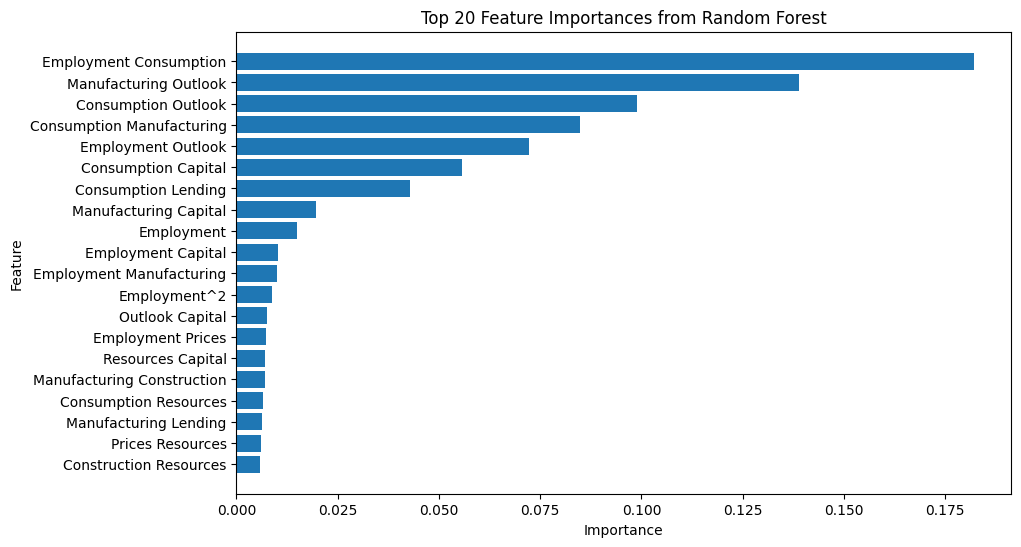

In [85]:
# Trying a random forest to see which interactions matter

from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Define topic columns (X) and dependent variable (y)
topic_columns = ["Employment", "Prices", "Consumption", "Manufacturing", 
                 "Construction", "Lending", "Uncertainty", "Resources", 
                 "Transportation", "Outlook", "Labor", "Capital", "Trade"]
X = merged_data[topic_columns]
y = merged_data['normalized_sentiment']

from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial and interaction terms
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Get feature names for the generated terms
feature_names = poly.get_feature_names_out(input_features=topic_columns)

# Convert to a DataFrame for better interpretation
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.2, random_state=755)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=755)

# Fit the model
rf_model.fit(X_train, y_train)

# Evaluate the model performance
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print(f"Training R^2: {train_score:.4f}")
print(f"Testing R^2: {test_score:.4f}")

# Extract feature importances
feature_importances = pd.DataFrame({
    'Feature': X_poly_df.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the top 20 most important features
print(feature_importances.head(20))

import matplotlib.pyplot as plt

# Plot the top 20 most important features
top_features = feature_importances.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()




In [87]:
# Take most important variables from GLS model and create interactions with just those variables

# Define the most important variables based on GLS results
important_variables = ["Consumption", "Manufacturing", "Resources", "Outlook", "Capital"]

# Create a subset of X
X = merged_data[important_variables]
y = merged_data['normalized_sentiment']

from sklearn.preprocessing import PolynomialFeatures

# Generate interaction terms without squared terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Get feature names for the generated terms
feature_names = poly.get_feature_names_out(input_features=X.columns)

# Convert to DataFrame for easier interpretation
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

import statsmodels.api as sm

# Add a constant for the regression
X_poly_df = sm.add_constant(X_poly_df)

# Fit the OLS model
model = sm.OLS(y, X_poly_df).fit()

# Print the summary of the results
model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     normalized_sentiment   R-squared:                       0.711
Model:                              OLS   Adj. R-squared:                  0.701
Method:                   Least Squares   F-statistic:                     74.43
Date:                  Sun, 01 Dec 2024   Prob (F-statistic):          6.14e-112
Time:                          21:47:51   Log-Likelihood:                 87.866
No. Observations:                   470   AIC:                            -143.7
Df Residuals:                       454   BIC:                            -77.29
Df Model:                            15                                         
Covariance Type:              nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.8719      0.055     15.913      0.000       0.764       0.980
Consumption                  -0.0228      0.005     -4.377      0.000      -0.033      -0.013
Manufacturing                -0.0362      0.011     -3.283      0.001      -0.058      -0.015
Resources                    -0.0318      0.007     -4.539      0.000      -0.046      -0.018
Outlook                      -0.0495      0.019     -2.628      0.009      -0.087      -0.013
Capital                      -0.0440      0.011     -3.829      0.000      -0.067      -0.021
Consumption Manufacturing    -0.0005      0.000     -1.102      0.271      -0.001       0.000
Consumption Resources         0.0017      0.001      2.427      0.016       0.000       0.003
Consumption Outlook           0.0007      0.001      0.711      0.478      -0.001       0.002
Consumption Capital          -0.0014      0.001     -1.577      0.115      -0.003       0.000
Manufacturing Resources       0.0012      0.001      1.113      0.266      -0.001       0.003
Manufacturing Outlook         0.0027      0.002      1.756      0.080      -0.000       0.006
Manufacturing Capital         0.0008      0.001      0.786      0.432      -0.001       0.003
Resources Outlook            -0.0028      0.002     -1.654      0.099      -0.006       0.001
Resources Capital             0.0044      0.001      3.262      0.001       0.002       0.007
Outlook Capital              -0.0007      0.002     -0.362      0.718      -0.004       0.003
==============================================================================
Omnibus:                       10.603   Durbin-Watson:                   0.900
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.746
Skew:                          -0.336   Prob(JB):                      0.00464
Kurtosis:                       3.313   Cond. No.                         982.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Multiply important_variables by normalized_sentiment
for var in important_variables:
    merged_data[var + '_times_sentiment'] = merged_data[var] * merged_data['normalized_sentiment']


# Run a logistic regression with these new variables
import statsmodels.api as sm

# Define X as including all the topic columns
X = merged_data[[var + '_times_sentiment' for var in important_variables]]
X = sm.add_constant(X)
y = merged_data['normalized_sentiment']


# Define the most important variables based on GLS results
important_variables = ["Consumption", "Manufacturing", "Resources", "Outlook", "Capital"]

# Create a subset of X
X = merged_data[important_variables]
y = merged_data['normalized_sentiment']

from sklearn.preprocessing import PolynomialFeatures

# Generate interaction terms without squared terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Get feature names for the generated terms
feature_names = poly.get_feature_names_out(input_features=X.columns)

# Convert to DataFrame for easier interpretation
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

import statsmodels.api as sm

# Add a constant for the regression
X_poly_df = sm.add_constant(X_poly_df)

# Fit the OLS model
model = sm.OLS(y, X_poly_df).fit()

# Print the summary of the results
model.summary()



                      Feature  Importance
6   Consumption Manufacturing    0.219312
11      Manufacturing Outlook    0.188670
8         Consumption Outlook    0.174629
9         Consumption Capital    0.127680
12      Manufacturing Capital    0.060884
1                 Consumption    0.045747
7       Consumption Resources    0.037636
13          Resources Outlook    0.032130
14          Resources Capital    0.027650
3                   Resources    0.019461


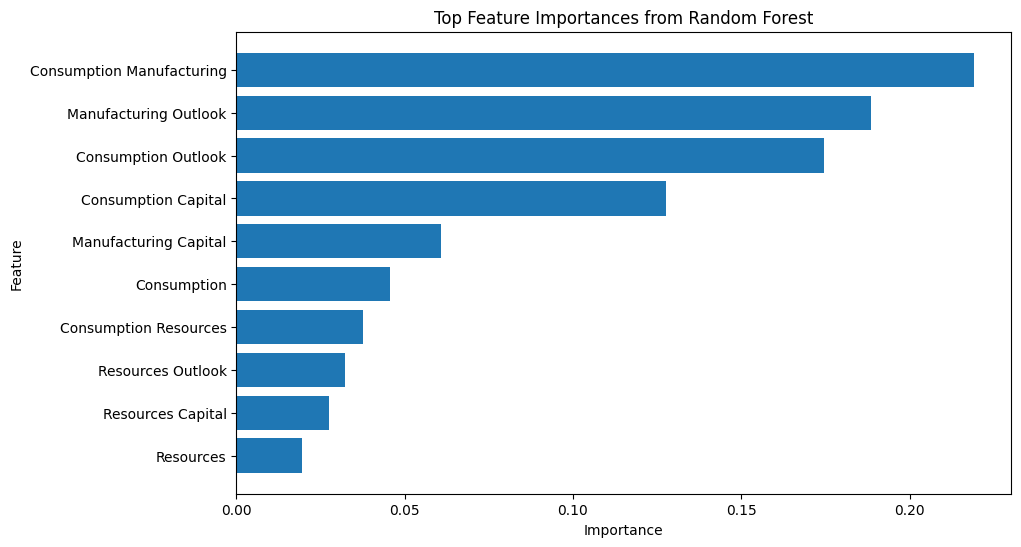

In [89]:
from sklearn.ensemble import RandomForestRegressor

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)

# Fit Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate feature importance
feature_importances = pd.DataFrame({
    'Feature': X_poly_df.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print top features
print(feature_importances.head(10))

import matplotlib.pyplot as plt

# Plot feature importance
top_features = feature_importances.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()


# Visualization of topic impacts on GDP/Sentiment scatter plots

From Lambert: Do Seaborn scatter plots of conditional effects. Count of topic is Y and sentiment is X: Hue is recession or not.

Interpretation: When this topic appears during a recession, it has more of a negative sentiment; Run a couple and find one or two that are interesting. Throw into discussion section.


In [ ]:
# Create dummy variable for dates of recessions
    # Dates defined by Business Cycle Dating Committee of the NBER

df = merged_data.copy()
df["Recession"] = 0
df.loc[(df["DATE"] >= "1969-12-01") & (df["DATE"] <= "1970-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1973-11-01") & (df["DATE"] <= "1975-03-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1980-01-01") & (df["DATE"] <= "1980-06-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1981-07-01") & (df["DATE"] <= "1982-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "1990-07-01") & (df["DATE"] <= "1991-03-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2001-03-01") & (df["DATE"] <= "2001-11-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2007-12-01") & (df["DATE"] <= "2009-06-01"), "Recession"] = 1
df.loc[(df["DATE"] >= "2020-02-01") & (df["DATE"] <= "2020-04-01"), "Recession"] = 1

import seaborn as sns
import matplotlib.pyplot as plt

# Define the topic columns
topic_columns = ["Employment", "Prices", "Consumption", "Manufacturing", 
                 "Construction", "Lending", "Uncertainty", "Resources", 
                 "Transportation", "Outlook", "Labor", "Capital", "Trade"]

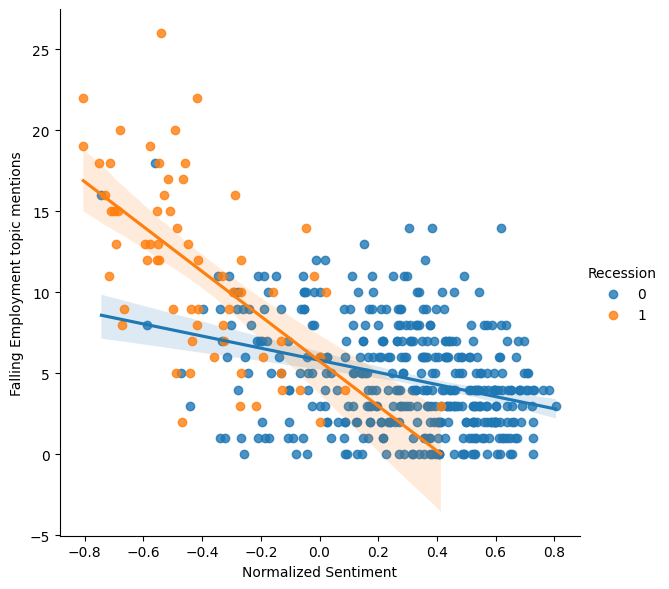

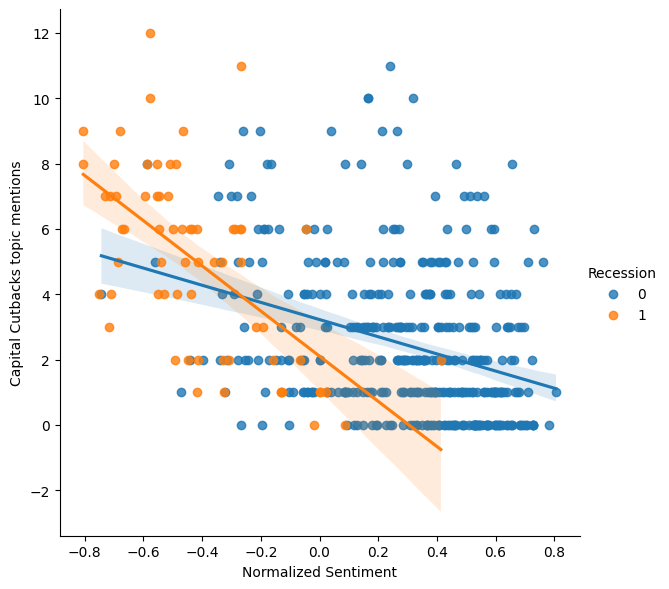

In [33]:
# Use lmplot in seaborn to do a scatter plot with a regression line
    # Y is count of a topic
    # X is normalized sentiment
    # Color is recession dummy variable

### This is the full list; only running the two most interesting
# for topic in topic_columns:
#     sns.lmplot(x='normalized_sentiment', y=topic, data=df, hue='Recession', height=6)
#     plt.show()

# Employment and Capital matter most
# Plot just those two
sns.lmplot(x='normalized_sentiment', y='Employment', data=df, hue='Recession', height=6)
plt.xlabel('Normalized Sentiment')
plt.ylabel('Falling Employment topic mentions')
# Save the plot
plt.savefig('EmploymentScatter.png')
plt.show()

sns.lmplot(x='normalized_sentiment', y='Capital', data=df, hue='Recession', height=6)
plt.xlabel('Normalized Sentiment')
plt.ylabel('Capital Cutbacks topic mentions')
plt.savefig('CapitalScatter.png')
plt.show()

### Test if difference in slopes is statistically significant

In [38]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
from scipy.stats import norm  # Import norm from scipy.stats

# Function to fit regression models for recession vs. non-recession
def regression_by_recession(df, y_var):
    # Separate data
    df_rec = df[df['Recession'] == 1]
    df_non_rec = df[df['Recession'] == 0]

    # Add constant for intercept
    X_rec = sm.add_constant(df_rec['normalized_sentiment'])
    X_non_rec = sm.add_constant(df_non_rec['normalized_sentiment'])

    # Fit regression models
    model_rec = sm.OLS(df_rec[y_var], X_rec).fit()
    model_non_rec = sm.OLS(df_non_rec[y_var], X_non_rec).fit()

    return model_rec, model_non_rec

# Run regressions for Employment and Capital
employment_rec, employment_non_rec = regression_by_recession(df, 'Employment')
capital_rec, capital_non_rec = regression_by_recession(df, 'Capital')

# Extract slopes and standard errors
slope_employment_rec, se_employment_rec = employment_rec.params[1], employment_rec.bse[1]
slope_employment_non_rec, se_employment_non_rec = employment_non_rec.params[1], employment_non_rec.bse[1]

slope_capital_rec, se_capital_rec = capital_rec.params[1], capital_rec.bse[1]
slope_capital_non_rec, se_capital_non_rec = capital_non_rec.params[1], capital_non_rec.bse[1]

# Function for statistical significance test (z-test)
def slope_difference_test(slope1, se1, slope2, se2):
    diff = slope1 - slope2
    se_diff = np.sqrt(se1**2 + se2**2)  # Standard error of the difference
    z_score = diff / se_diff  # Compute z-score
    p_value = 2 * (1 - norm.cdf(abs(z_score)))  # Use norm.cdf from scipy.stats
    return diff, z_score, p_value

# Test significance of slope differences
employment_diff, employment_z, employment_p = slope_difference_test(
    slope_employment_rec, se_employment_rec, slope_employment_non_rec, se_employment_non_rec
)

capital_diff, capital_z, capital_p = slope_difference_test(
    slope_capital_rec, se_capital_rec, slope_capital_non_rec, se_capital_non_rec
)

# Display results in a DataFrame
results_df = pd.DataFrame({
    "Variable": ["Employment", "Capital"],
    "Slope (Recession)": [slope_employment_rec, slope_capital_rec],
    "Slope (Non-Recession)": [slope_employment_non_rec, slope_capital_non_rec],
    "Slope Difference": [employment_diff, capital_diff],
    "Z-score": [employment_z, capital_z],
    "P-value": [employment_p, capital_p]
})

results_df


C:\Users\MCOB PHD 14\AppData\Local\Temp\ipykernel_4104\161668290.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope_employment_rec, se_employment_rec = employment_rec.params[1], employment_rec.bse[1]
C:\Users\MCOB PHD 14\AppData\Local\Temp\ipykernel_4104\161668290.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope_employment_non_rec, se_employment_non_rec = employment_non_rec.params[1], employment_non_rec.bse[1]
C:\Users\MCOB PHD 14\AppData\Local\Temp\ipykernel_4104\161668290.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alway

,Variable,Slope (Recession),Slope (Non-Recession),Slope Difference,Z-score,P-value
0,Employment,-13.832873,-3.736993,-10.095880,-4.373880,0.000012
1,Capital,-6.914538,-2.627456,-4.287082,-3.551862,0.000383
